# 5. ニューラルネットワークによる画像分類

## 5.1 ニューラルネットワークとディープラーニング

### ディープラーニング
- 通常のニューラルネットワークよりも深く(=層数が大きい)、パラメータ(重み)の数が大きいネットワークを用いた学習
    - 明確な定義はない
- 2000年代なかばまではニューラルネットワークは数層程度だった
    - それ以上の層数ではうまく訓連できなかった
    - 勾配消失
- ブレークスルー
    - コンボリューションネットワークの発明
    - 訓練方法の発展
    - データ量の飛躍的増大
    - 計算機の発展(特にGPU)
    - フレームワークの整備 PyTorch, TensorFlow

## 5.2 PyTorchの紹介
- Torch というライブラリをPython向けに整備し直したもの
    - Pythonのライブラリとしては比較的後発だが、実は歴史は古い
    - 現在TensorFlowと業界を2分
    - 研究者の領域ではPyTorch優勢

- PyTorchでなにができるか
    - ニューラルネットワークのモデルの定義
    - 訓練データを使った訓連

- PyTorch(などのNNフレームワーク)の利点
    - 通常の計算を行うかのように、NNモデルを定義
    - 誤差逆伝搬に必要な自動微分


## 5.3 CNNの構造

#### 画像処理の問題点
- 特徴量の数が多い  - 個々のピクセルがそれぞれ特徴量になる
      ex. 100 x 100 x 3 のカラー画像なら 30000
- これを通常の(全結合)ニューラルネットワークで処理しようとするとパラメータ(重み)の数が大きくなる  
      ex. 隠れ層も100x100とすると、30000 x 10000 で $3 \times 10^8$  
          隠れ層の数が増えると更に
- パラメータ数が増えると、訓連に必要なデータ数、訓連時間ともに増大する

<img src="images/mlp.png" width="500"/>       

#### コンボリューション (畳み込み)
- 画像の中の相互に遠いピクセルとはあまり関係ない  
  → 周囲のピクセルとの相関だけ見ればよさそう
- あるピクセルとその周囲のピクセルとの関係は、画像の中のどのピクセルでもたぶん同じ
  - 同じ重みをすべてのピクセルに使い回せる
  - 重みの数が飛躍的に減る  
    例: 5x5x3 のコンボリューションなら、画像のピクセル数によらず、重みは75個  
- チャンネル
  - 同じ近傍から別の情報を引き出すために、全く独立した重み群を複数用意する
  - 一般に画像系ネットワークの各層は、幅 x 高さ x チャンネル の3次元で構成される

<img src="images/convolution.svg" width="500"/>


#### プーリング
- 層のサイズを減らすために、複数のピクセルの情報を1つに集約する
- max pooling - 複数のピクセルの最大値をとる
- average pooling - 複数のピクセルの平均値をとる
  - 例: 2x2のピクセルを一つのピクセルにまとめる。層のサイズは1/4になる。
- プーリングには重みはない  

#### ネットワークの例:

128 x 128 x 3 の画像を10クラスに分類するネットワークの例

http://alexlenail.me/NN-SVG/LeNet.html で作成。

<img src="images/lenet-cropped.svg" width="800"/>



## 5.4 データオーグメンテーション

- CNN を訓連するには、大量のデータが必要
- シフト不変性、回転不変性をデータで補う必要がある

<img src="images/invariant.png" width="600" />

- 1枚の画像にさまざまな変換を施して多数の訓連用画像を得る

In [1]:
# hide
!pip install azure-cognitiveservices-search-imagesearch
!pip install fastai

In [22]:
from fastai.vision.all import *

# fastai 本の utils より

def search_images_bing(key, term, min_sz=128, max_images=150):    
     params = {'q':term, 'count':max_images, 'min_height':min_sz, 'min_width':min_sz}
     headers = {"Ocp-Apim-Subscription-Key":key}
     search_url = "https://api.bing.microsoft.com/v7.0/images/search"
     response = requests.get(search_url, headers=headers, params=params)
     response.raise_for_status()
     search_results = response.json()    
     return L(search_results['value'])


In [25]:
key = '321531940cbc4d67974cd866691b408b'
results = search_images_bing(key, 'grizzly bear')

In [32]:
results.attrgot('contentUrl')


(#150) ['http://2.bp.blogspot.com/-NjMTuklENdE/UHzVv_8dIxI/AAAAAAAAA-U/tNBsQDn8kFI/s1600/Grizzly+Bear+Pic.jpg','https://d3d0lqu00lnqvz.cloudfront.net/media/media/897b2e5d-6d4c-40fa-bbe8-6829455747e2.jpg','http://3.bp.blogspot.com/-S1scRCkI3vY/UHzV2kucsPI/AAAAAAAAA-k/YQ5UzHEm9Ss/s1600/Grizzly%2BBear%2BWildlife.jpg','https://cdn.britannica.com/18/161718-050-2DB34DD6/Grizzly-bear.jpg','https://s1.ibtimes.com/sites/www.ibtimes.com/files/styles/embed/public/2017/11/20/grizzly-bear.jpg','https://thelatebloomerhiker.files.wordpress.com/2014/11/grizzly-bear-22224-1920x1200.jpg','https://tetonvalleylodge.com/wp-content/uploads/2015/04/grizzly-bear-idaho.jpg','https://taylormoney.com/wp-content/uploads/2020/05/grizzly-bear-1564257594hjC.jpg','http://4.bp.blogspot.com/-3WcCGQ1bzJI/UXcshw5QEwI/AAAAAAAAIns/gfJpUVE0FK8/s1600/Grizzly-Bear-7.jpg','https://www.goodfreephotos.com/albums/animals/mammals/grizzly-bear-in-the-wild.jpg'...]

In [35]:
bear_types = 'grizzly', 'black', 'teddy'
path = Path('bears')
if not path.exists():
    path.mkdir()
    for o in bear_types:
        dest = (path/o)
        dest.mkdir(exist_ok=True)
        results = search_images_bing(key, f'{o} bear')
#        print(results.attrgot('contentUrl'))
        download_images(dest, urls=results.attrgot('contentUrl'))


 Download of https://s3.amazonaws.com/images.gearjunkie.com/uploads/2020/05/grizzly-bear.jpg has failed after 5 retries
 Fix the download manually:
$ mkdir -p bears/grizzly
$ cd bears/grizzly
$ wget -c https://s3.amazonaws.com/images.gearjunkie.com/uploads/2020/05/grizzly-bear.jpg
$ tar xf grizzly-bear.jpg
 And re-run your code once the download is successful


 Download of https://media.spokesman.com/photos/2018/08/18/Grizzly_Bears_Montana.JPG.jpg has failed after 5 retries
 Fix the download manually:
$ mkdir -p bears/grizzly
$ cd bears/grizzly
$ wget -c https://media.spokesman.com/photos/2018/08/18/Grizzly_Bears_Montana.JPG.jpg
$ tar xf Grizzly_Bears_Montana.JPG.jpg
 And re-run your code once the download is successful


 Download of https://bozone.com/site/wp-content/uploads/2019/03/GRIZZLY.jpeg has failed after 5 retries
 Fix the download manually:
$ mkdir -p bears/grizzly
$ cd bears/grizzly
$ wget -c https://bozone.com/site/wp-content/uploads/2019/03/GRIZZLY.jpeg
$ tar xf GRIZZLY

In [38]:
bears = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128)
)

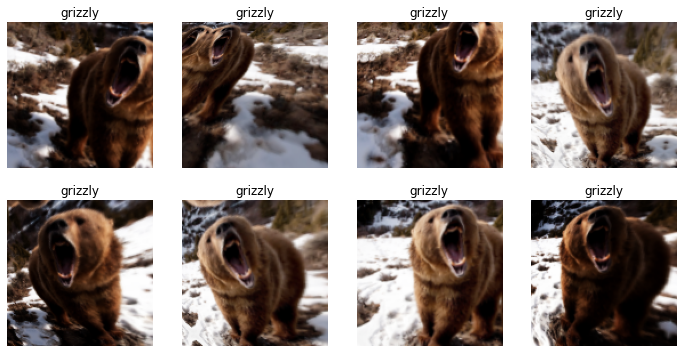

In [39]:
bears_a = bears.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls = bears_a.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)